In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load data and peek into it

In [72]:
# Parsing date 
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
sales=pd.read_csv('sales_train.csv', parse_dates=['date'], date_parser=dateparse)

In [164]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [67]:
#Checking type of data to verify parsing
type(sales.date[0])

pandas._libs.tslibs.timestamps.Timestamp

In [108]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935825e+06,2.935825e+06,2.935825e+06,2.935825e+06,2.935825e+06
mean,1.456992e+01,3.300171e+01,1.019721e+04,8.908558e+02,1.242643e+00
std,9.422984e+00,1.622699e+01,6.324298e+03,1.729806e+03,2.618845e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [165]:
items=pd.read_csv('items.csv')
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [156]:
#items.describe()

In [157]:
item_categories=pd.read_csv('item_categories.csv')
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
shops=pd.read_csv('shops.csv')
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [159]:
#sample_submission=pd.read_csv('sample_submission.csv')
#sample_submission.head()

In [17]:
test=pd.read_csv('test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


<b>The problem requires us to predict the monthly sales per shop per item

##  Check for missing values in data

In [40]:
sales.isnull().any()

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

In [31]:
sales.isna().any()

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

We dont have any missing/null values 

## Checking for outliers

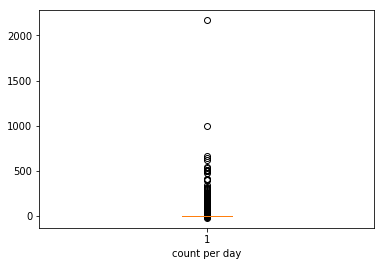

In [58]:
plt.boxplot(sales.item_cnt_day)
plt.xlabel('count per day')
plt.show()

There are some outliers with values greater than 1000.

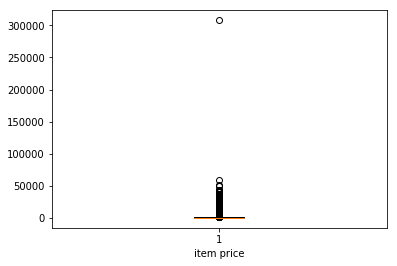

In [57]:
plt.boxplot(sales.item_price)
plt.xlabel('item price')
plt.show()

There is a record with negative value for item price and record with strangely high price. We can consider them as outliers.

In [163]:
sales=sales[(sales.item_cnt_day<1000) & (sales.item_price>0) & (sales.item_price<600000)]

(2935822, 6)

## Drop duplicates

In [81]:
subset=['date', 'date_block_num', 'shop_id', 'item_id',
       'item_cnt_day']
#print(sales.duplicated(subset=subset).value_counts())
sales.drop_duplicates(inplace=True, subset= subset)

False    2935825
dtype: int64


In [78]:
sales.shape


(2935825, 6)

## Filtering data

In [89]:
trainItems=sales.item_id.unique()
len(trainItems)

array([22154,  2552,  2554, ...,  7610,  7635,  7640])

In [90]:
testItems=test.item_id.unique()
len(testItems)

We have data of 21807 different items but test data has only 5100 different items. 
Hence we dont need all items. Lets create a subset with only required data.

In [136]:
sales_subset = sales[sales.item_id.isin(testItems)]
sales_subset.shape

(1445996, 6)

In [137]:
len(sales.shop_id.unique())

60

In [138]:
len(test.shop_id.unique())

42

The training data has 60 different shops while test data has 42 different shops. Lets create subset of training data with just required shops.

In [139]:
sales_subset = sales_subset[sales_subset.shop_id.isin(test.shop_id.unique())]

In [140]:
sales_subset.shape

(1224429, 6)

In [97]:
newItems =[i for i in testItems if i not in trainItems]
len(newItems)

363

There are 363 items which are new to the test set and we do not have any training data for those.

## Aggregating data

In [142]:
salesMonthly=sales_subset.sort_values('date').groupby(['item_id','shop_id','date_block_num'], as_index=False)
salesMonthly= salesMonthly.agg({'item_cnt_day': ['sum','count'], 'item_price': ['mean']})
salesMonthly.columns=['item_id', 'shop_id', 'date_block_num', 'qty', 'transactions', 'average_price']
salesMonthly.head(10)

,item_id,shop_id,date_block_num,qty,transactions,average_price
0,30,2,2,1.0,1,359.0
1,30,2,5,1.0,1,399.0
2,30,2,15,1.0,1,169.0
3,30,2,16,1.0,1,169.0
4,30,3,1,4.0,4,399.0
5,30,3,2,5.0,4,399.0
6,30,3,3,2.0,2,399.0
7,30,3,4,2.0,2,399.0
8,30,3,5,1.0,1,399.0
9,30,3,9,1.0,1,169.0


In [185]:
shopIds = salesMonthly.shop_id.unique()
itemIds = salesMonthly.item_id.unique()

#Creating an empty dataframe 
df=[]
for i in range(0,34):
    for shop in shopIds:
        for item in itemIds:
            df.append([i,shop,item])
            
         

In [198]:
df=pd.DataFrame(data=df, columns=['date_block_num','shop_id','item_id'])
#Empty placeholder dataframe
df.head()

,date_block_num,shop_id,item_id
0,0,2,30
1,0,2,31
2,0,2,32
3,0,2,33
4,0,2,38


Now we have created an empty dataframe with placeholder for each item in each shop for each month. Now we can join this with aggregated monthly data to get complete and uniform picture.

In [190]:
df_filled=pd.merge(df,salesMonthly,how='left',on=['date_block_num', 'shop_id', 'item_id'])


In [191]:
df_filled.shape

(6734448, 6)

Verified that shape of this dataframe is same as empty data frame which means we have records for each item each shop each month!

In [192]:
df_filled.head()

,date_block_num,shop_id,item_id,qty,transactions,average_price
0,0,2,30,NaN,NaN,NaN
1,0,2,31,NaN,NaN,NaN
2,0,2,32,NaN,NaN,NaN
3,0,2,33,1.0,1.0,499.0
4,0,2,38,NaN,NaN,NaN


In [193]:
#Replace missing values with zeros.
df_filled.fillna(0,inplace=True)
df_filled.head()

,date_block_num,shop_id,item_id,qty,transactions,average_price
0,0,2,30,0.0,0.0,0.0
1,0,2,31,0.0,0.0,0.0
2,0,2,32,0.0,0.0,0.0
3,0,2,33,1.0,1.0,499.0
4,0,2,38,0.0,0.0,0.0


Adding category id in the data.

In [194]:
df_filled=pd.merge(df_filled,items, on=['item_id'])

In [196]:
df_filled=df_filled.drop(['item_name'], axis=1)
df_filled.head()

,date_block_num,shop_id,item_id,qty,transactions,average_price,item_category_id
0,0,2,30,0.0,0.0,0.0,40
1,0,3,30,0.0,0.0,0.0,40
2,0,4,30,0.0,0.0,0.0,40
3,0,5,30,0.0,0.0,0.0,40
4,0,6,30,0.0,0.0,0.0,40


## Feature engineering 
<li>
    Year
 <li> 
     Month
 <li>
     Revenue
 <li> 
     Merging category
     

In [213]:
df_filled['month'] = df_filled.date_block_num % 12
df_filled['year'] = (df_filled.date_block_num // 12) + 2013
df_filled['sale']= df_filled.qty * df_filled.average_price

In [229]:
#df_filled.head()

In [227]:
df_filled.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.0,16.500000,9.810709,0.0,8.00,16.5,25.00,3.300000e+01
shop_id,6734448.0,31.642857,17.561894,2.0,16.00,34.5,47.00,5.900000e+01
item_id,6734448.0,11041.890161,6210.744436,30.0,5385.25,11265.5,16068.25,2.216700e+04
qty,6734448.0,0.240222,3.456638,-4.0,0.00,0.0,0.00,2.253000e+03
transactions,6734448.0,0.181816,0.904729,0.0,0.00,0.0,0.00,3.100000e+01
average_price,6734448.0,81.230079,534.732651,0.0,0.00,0.0,0.00,4.299000e+04
item_category_id,6734448.0,46.222010,16.693749,2.0,37.00,43.0,58.00,8.300000e+01
month,6734448.0,5.205882,3.323530,0.0,2.00,5.0,8.00,1.100000e+01
year,6734448.0,2013.941176,0.802246,2013.0,2013.00,2014.0,2015.00,2.015000e+03
sale,6734448.0,256.172538,6085.868031,-33490.0,0.00,0.0,0.00,6.212880e+06


## EDA


### Item with maximum transactions

In [287]:
df_filled.groupby(['item_id','item_category_id']).sum()[['transactions']].sort_values(by='transactions',ascending=False)[:5]

,,transactions
item_id,item_category_id,
20949,71,26488.0
5822,35,7919.0
17717,79,7896.0
2808,30,6337.0
4181,75,5985.0


### Item with maximum qty sold

In [284]:
df_filled.groupby('item_id').sum()[['qty']].sort_values(by='qty',ascending=False)[:5]

,qty
item_id,
20949,154077.0
2808,13955.0
3732,13582.0
17717,13553.0
5822,12268.0


### Items with highest gross sale

In [288]:
df_filled.groupby(['item_id','item_category_id']).sum()[['sale']].sort_values(by='sale',ascending=False)[:5]

,,sale
item_id,item_category_id,
6675,12,1.844933e+08
3732,19,3.582660e+07
3734,23,2.604079e+07
3731,30,1.940635e+07
3733,20,1.893981e+07


### Category with highest total sale value

In [291]:
temp=df_filled.groupby(['item_category_id']).sum()[['sale']].sort_values(by='sale', ascending=False)[:5]
pd.merge(temp,item_categories, how='inner', on='item_category_id')

,item_category_id,sale,item_category_name
0,20,2.884933e+08,Игры - PS4
1,12,1.963003e+08,Игровые консоли - PS4
2,19,1.880543e+08,Игры - PS3
3,30,1.490549e+08,Игры PC - Стандартные издания
4,23,1.379423e+08,Игры - XBOX 360


### Shop with highest sale

In [293]:
df_filled.groupby(['shop_id']).sum()[['sale']].sort_values(by='sale', ascending=False)[:5]

,sale
shop_id,
31,1.364593e+08
25,1.287565e+08
42,9.657444e+07
28,9.657005e+07
12,7.074240e+07


### Year with highest sale

In [294]:
df_filled.groupby(['year']).sum()[['sale']].sort_values(by='sale', ascending=False)[:5]

,sale
year,
2014,6.870451e+08
2015,6.521342e+08
2013,3.860013e+08


### Month with highest sale

In [296]:
df_filled.groupby(['month']).sum()[['sale']].sort_values(by='sale', ascending=False)

,sale
month,
11,2.240682e+08
8,1.796728e+08
9,1.698066e+08
10,1.486298e+08
2,1.398276e+08
1,1.339307e+08
0,1.296984e+08
7,1.249010e+08
4,1.236344e+08


Plot sale by month for each year. Three seperate graphs

In [313]:
temp=df_filled.groupby(['year','month']).sum()[['sale']].sort_values(by='sale', ascending=False)
temp.loc[2013]

,sale
month,
11,9.777369e+07
10,6.195426e+07
8,4.652956e+07
9,3.617727e+07
2,2.462821e+07
5,2.220691e+07
7,1.804053e+07
6,1.793312e+07
1,1.765320e+07


In [ ]:
sales_2013=temp.loc[2013].sale